In [2]:
import os
import cv2
import numpy as np
from tqdm import tqdm

In [3]:



REBUILD_DATA = True

class DogsVsCats():
    imageSize = 50
    cats = "CatsVsDogs/PetImages/Cat"
    dogs = "CatsVsDogs/PetImages/Dog"
    labels = {cats : 0, dogs : 1}
    trainingData = []
    catCount = 0
    dogCount = 0
    
    
    def makeTrainingData(self):
        for label in self.labels:
            print(label)
            for f in tqdm(os.listdir(label)):
                try:
                    path = os.path.join(label,f)
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (self.imageSize, self.imageSize))
                    # np.eye(2).... will produce [0,1] or [1,0]
                    self.trainingData.append([np.array(img), np.eye(2)[self.labels[label]]])
                    # Here we are using hot vectors (like bitmask if second is one it's a dog)
                    if label == self.cats:
                        self.catCount += 1
                    elif label == self.dogs:
                        self.dogCount += 1
                except Exception as e:
                    #print(str(e))
                    pass # if some images are corrupted or not working
        np.random.shuffle(self.trainingData)
        np.save("trainingData.npy", self.trainingData)
        print("Cats:", self.catCount)
        print("Dogs:", self.dogCount)
        
        
if REBUILD_DATA:
    dogsVsCats = DogsVsCats()
    dogsVsCats.makeTrainingData()

  1%|▌                                                                             | 82/12501 [00:00<00:15, 814.06it/s]

CatsVsDogs/PetImages/Cat


  1%|▍                                                                             | 74/12501 [00:00<00:17, 727.42it/s]

CatsVsDogs/PetImages/Dog


100%|███████████████████████████████████████████████████████████████████████████| 12501/12501 [00:25<00:00, 486.59it/s]


Cats: 12476
Dogs: 12470


In [3]:
trainingData = np.load("trainingData.npy", allow_pickle = True)



In [4]:
print(len(trainingData))

24946


In [5]:
print(trainingData[0])

[array([[115, 118, 119, ..., 108, 108, 108],
       [114,  70, 115, ..., 108, 108, 108],
       [114,   5,  10, ..., 107, 108, 110],
       ...,
       [115, 118, 118, ..., 112, 111, 109],
       [127, 129, 134, ..., 113, 114, 111],
       [ 83,  46,  63, ..., 115, 112, 112]], dtype=uint8)
 array([1., 0.])]


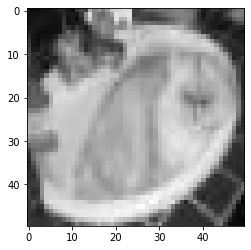

In [6]:
import matplotlib.pyplot as plt

plt.imshow(trainingData[1][0], cmap="gray")
plt.show()

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # Kernel/Window is 5
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)
        
        x = torch.randn(50,50).view(-1,1,50,50)
        self._to_linear = None
        self.convs(x) # part of the forward
        
        self.fc1 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(512, 2)
        
        
    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)),(2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)),(2,2))        
        x = F.max_pool2d(F.relu(self.conv3(x)),(2,2))
        
        #print(x[0].shape)
        if self._to_linear is None:
            self._to_linear = x[0].shape[0] * x[0].shape[1] * x[0].shape[2]
            
        return x
    
    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)
    
net = Net()

In [8]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr = 0.001)
lossFunction = nn.MSELoss()

X = torch.Tensor([i[0] for i in trainingData]).view(-1, 50, 50)
X = X/255.0 # just scaling to make it between 0,1

Y = torch.Tensor([i[1] for i in trainingData])

valPercent = 0.1
valSize = int(len(X) * valPercent)
#print(valSize)

In [14]:
trainX = X[:-valSize]
trainY = Y[:-valSize]

testX = X[-valSize:]
testY = Y[-valSize:]

print(len(trainX))
print(len(testX))

22452
2494


In [15]:
batchSize = 100
epochs = 1
for epoch in range(epochs):
    for i in tqdm(range(0, len(trainX), batchSize)):
        #print(i, i + batchSize)
        batchX = trainX[i:i+batchSize].view(-1,1,50,50)
        batchY = trainY[i:i+batchSize]
        
        net.zero_grad() # or optimizer.zero_grad because 1 optimizer exists
        outputs = net(batchX)
        loss = lossFunction(outputs, batchY)
        loss.backward()
        optimizer.step()
        
print(loss)

100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [01:54<00:00,  1.97it/s]

tensor(0.2134, grad_fn=<MseLossBackward>)


In [16]:
correct = 0
total = 0

with torch.no_grad():
    for i in tqdm(range(len(testX))):
        realClass = torch.argmax(testY[i])
        netOut = net(testX[i].view(-1,1,50,50))[0]
        predictedClass = torch.argmax(netOut)
        if predictedClass == realClass:
            correct += 1
        total += 1
print("Accurancy:", round(correct/total,3))

100%|█████████████████████████████████████████████████████████████████████████████| 2494/2494 [00:06<00:00, 393.18it/s]

Accurancy: 0.702
